In [1]:
import re
import warnings

import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.exceptions import DataConversionWarning
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(1966)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
# read in cleaned data
all_data = pd.read_csv("data/combined_data.csv").set_index("user_id")

In [3]:
df = all_data.copy().drop("primary_language_motivation_followup", axis=1) # ditch this free-response variable
original_types = df.select_dtypes(object)

""" ORDINAL """
def encode(column, _with):
    return df[column].apply(lambda s: _with.index(s))

# Select variables for encoding and specify ordering
ordinal = {
    "age" : ['No Response', 'Under 18', '18-34', '35 - 54', '55 - 74', '75 or older'],
    "annual_income" : ['No Response', '$0 - $10,000', '$11,000 - $25,000', '$151,000 or more', '$26,000 - $75,000', '$76,000 - $150,000'],
    "duolingo_usage" : ['No Response', "I don't use Duolingo", 'Less than once a month', 'Monthly', 'Weekly', 'Daily'],
    "primary_language_commitment" : ['No Response', "I'm not at all committed to learning this language.", "I'm slightly committed to learning this language.", "I'm moderately committed to learning this language.", "I'm very committed to learning this language.", "I'm extremely committed to learning this language."],
    "primary_language_review" : ['No Response', 'I am using Duolingo to learn this language for the first time.', "I am using Duolingo to review a language I've studied before."],
    "primary_language_proficiency" : ['No Response', 'Beginner', 'Intermediate', 'Advanced']
}
# encode
for var, ordering in ordinal.items():
    df[var] = encode(var, _with=ordering)

""" NOMINAL """  
# Select nominal variables for encoding
enc = OneHotEncoder(sparse=False)
nominal = ["country", "employment_status", "gender", "primary_language_motivation", "duolingo_platform"]

# encode
enc.fit(df[nominal])
one_hot_names = enc.get_feature_names()
one_hot = enc.transform(df[nominal])

# rename to make more sense
namer = dict((f"x{i}", n) for i, n in enumerate(nominal))
nominal_names = [re.sub("x[0-9]+", namer[re.findall("x[0-9]+", n)[0]], n) for n in one_hot_names]
nominal_feats = pd.DataFrame(one_hot, columns=nominal_names)
nominal_feats["user_id"] = df.index
nominal_feats.set_index("user_id")

# modify df to include new columns instead
df.drop(nominal, axis=1, inplace=True)
df.join(nominal_feats, how="inner")

""" BINARY """
# Select binary variables for encoding
binary = {
    "duolingo_subscriber" : (lambda s: 1 if "Yes" in s or "prev" in s else -1),
    "student" : (lambda s: 1 if "time" in s else -1)
}
for var, function in binary.items():
    df[var] = df[var].apply(function)
    
""" DATETIME """
df["duolingo_start_date"] = pd.to_datetime(df["duolingo_start_date"]).apply(lambda d: d.timestamp())

### Scale Data for clustering later (needed for distance metric)
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
scaled_df["purchased_subscription"] = df["purchased_subscription"]

# Encode duolingo_start_date as numeric
display(original_types.head(3))
display(df.head(3))
display(scaled_df.head(3))

,age,annual_income,country,duolingo_platform,duolingo_subscriber,duolingo_usage,employment_status,gender,primary_language_commitment,primary_language_review,primary_language_motivation,primary_language_proficiency,student,duolingo_start_date
user_id,,,,,,,,,,,,,,
35c9fc6e72c911e99681dca9049399ef,18-34,"$26,000 - $75,000",JP,Android phone or tablet,"No, I have never paid for Duolingo Plus",Daily,Employed full-time,Male,I'm very committed to learning this language.,I am using Duolingo to review a language I've ...,I like to learn new languages,Advanced,Not currently a student,2016-07-08T05:45:00Z
35c9fdde72c911e98630dca9049399ef,18-34,"$26,000 - $75,000",JP,iPhone or iPad,"No, I have never paid for Duolingo Plus",Weekly,Employed full-time,Male,I'm slightly committed to learning this language.,I am using Duolingo to review a language I've ...,I need to be able to speak the local language ...,Intermediate,Not currently a student,2018-07-02T16:42:00Z
35c9feb072c911e9ab4cdca9049399ef,18-34,"$76,000 - $150,000",JP,iPhone or iPad,"Yes, I currently pay for Duolingo Plus",Daily,Employed full-time,Male,I'm moderately committed to learning this lang...,I am using Duolingo to review a language I've ...,I want to connect with my heritage or identity,Beginner,Not currently a student,2017-07-13T15:47:00Z


,age,annual_income,duolingo_subscriber,duolingo_usage,future_contact,other_resources,primary_language_commitment,primary_language_review,primary_language_proficiency,student,...,duolingo_start_date,highest_course_progress,took_placement_test,purchased_subscription,highest_crown_count,n_active_days,n_lessons_started,n_lessons_completed,longest_streak,n_days_on_platform
user_id,,,,,,,,,,,,,,,,,,,,,
35c9fc6e72c911e99681dca9049399ef,2,4,-1,5,True,2,4,2,3,-1,...,1.467957e+09,58,True,False,275,91,232,232,589,849
35c9fdde72c911e98630dca9049399ef,2,4,-1,4,True,0,2,2,2,-1,...,1.530550e+09,4,True,False,22,54,90,88,27,125
35c9feb072c911e9ab4cdca9049399ef,2,5,1,5,True,0,3,2,1,-1,...,1.499961e+09,11,False,True,17,30,49,47,30,479


,age,annual_income,duolingo_subscriber,duolingo_usage,future_contact,other_resources,primary_language_commitment,primary_language_review,primary_language_proficiency,student,...,duolingo_start_date,highest_course_progress,took_placement_test,purchased_subscription,highest_crown_count,n_active_days,n_lessons_started,n_lessons_completed,longest_streak,n_days_on_platform
user_id,,,,,,,,,,,,,,,,,,,,,
35c9fc6e72c911e99681dca9049399ef,-0.960263,1.034841,-0.671914,0.488263,0.527316,0.483671,0.480160,1.011082,2.425834,-0.477222,...,-0.381023,1.497646,1.138945,False,1.708888,1.020415,-0.078222,-0.026053,2.416277,0.380494
35c9fdde72c911e98630dca9049399ef,-0.960263,1.034841,-0.671914,-0.883072,0.527316,-1.093974,-1.671835,1.011082,0.779207,-0.477222,...,0.833803,-1.211098,1.138945,False,-0.863140,0.065979,-0.543462,-0.525965,-0.370195,-0.833555
35c9feb072c911e9ab4cdca9049399ef,-0.960263,1.653625,1.488287,0.488263,0.527316,-1.093974,-0.595838,1.011082,-0.867419,-0.477222,...,0.240124,-0.859964,-0.878006,True,-0.913971,-0.553115,-0.677792,-0.668301,-0.355321,-0.239946


# Identifying Features for Model

As all of our data is now numeric, we can begin to analyze it and determine which variables might be most valuable. By running through the mutual information of each feature and selecting the top 5, we can see that features associated with general user activity are the best predictors for if someone is a Duolingo subscriber. This is not particularly useful, as we would definitely suspect that users who pay for the service would use it more.  

Not finding a great deal of information within individual variables, we'll look instead to a subset of variables

In [4]:
# use mutual information 
train_df = df.drop(["purchased_subscription", "duolingo_subscriber"], axis=1)
test_df = df["purchased_subscription"]

features, labels = train_df.values, test_df.values
model = mutual_info_classif(features, labels)

In [5]:
best_col_idx = [v[0] for v in sorted(enumerate(model), key=lambda m: m[1], reverse=True)]
best_column_names = train_df.columns[best_col_idx]
mutual_info_variables = list(zip(best_column_names.to_list(), sorted(model, reverse=True)))

print("Total number of features:", len(features[0]), end="\n\n")
print("Variables with highest information:")
display(pd.DataFrame(mutual_info_variables[:5], columns=["Variable", "Information"]))
print("Variables with lowest information:")
display(pd.DataFrame(mutual_info_variables[-5:], columns=["Variable", "Information"]))

Total number of features: 20

Variables with highest information:


,Variable,Information
0,longest_streak,0.107725
1,n_lessons_started,0.104060
2,n_active_days,0.096142
3,n_lessons_completed,0.096116
4,duolingo_usage,0.064016


Variables with lowest information:


,Variable,Information
0,primary_language_proficiency,0.003636
1,future_contact,0.003072
2,other_resources,0.000000
3,survey_complete,0.000000
4,time_spent_seconds,0.000000


## Variable Subsets with Sequential Feature Selector

We've looked individually at features to see how much they can tell us alone, but is there a subset of variables that can synergize to unlock more predictive power together? We'll use a Sequential Feature Selector to search for this subset. We'll pick out 10 features and use 5-fold cross-validation. I've decided to use a RandomForest as a classifier here because it's relatively simple and I intend to use it afterward (and thus wish to have a good set of variables for it). We'll use the ROC curve to score the variable sets.  

---

We ultimately find that student-status, annual income, and features indicative of activity are our best predictive features for subscription. Let's now see how important each is in the prediction.

In [6]:
feature_selector = SFS(
    RandomForestClassifier(n_estimators=150, n_jobs=-1),
    k_features=10,
    forward=True,
    scoring="roc_auc",
    verbose=True,
    cv=5
).fit(train_df, test_df)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   34.8s finished
Features: 1/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   33.1s finished
Features: 2/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   31.8s finished
Features: 3/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   30.8s finished
Features: 4/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   30.7s finished
Features: 5/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   28.4s finished
Features: 6/10[Parallel(

In [7]:
best_feats = list(feature_selector.k_feature_names_)
best_feats

['annual_income',
 'duolingo_usage',
 'primary_language_commitment',
 'student',
 'time_spent_seconds',
 'duolingo_start_date',
 'highest_course_progress',
 'n_active_days',
 'n_lessons_started',
 'longest_streak']

# Model Building and Interpretation
We'll now reduce our data to the variables we've identified through feature selection, and try out a RandomForest  as well as AdaBoost. We'll do an 80-20 split of our data, and try out a few different metrics to evaluate performance.

---

We find that they perform about the same, so we then try to extract some information from the RandomForest. I like RandomForests because they tend to be fairly interpretable—we'll go ahead and look at the trained model's feature importances.

In [8]:
train_feats, test_feats, train_labels, test_labels = train_test_split(
    train_df[best_feats], test_df,
    test_size=0.2
) 

In [9]:
# Train RandomForest Model
clf1 = RandomForestClassifier(n_estimators=300, min_samples_split=4).fit(train_feats, train_labels)
y_pred_train = clf1.predict(train_feats)
y_pred_test  = clf1.predict(test_feats)

print("Performance on Training Data:")
print("\tF1 score:",         f1_score(y_true=train_labels, y_pred=y_pred_train))
print("\tAccuracy:",   accuracy_score(y_true=train_labels, y_pred=y_pred_train))
print("\tPrecision:", precision_score(y_true=train_labels, y_pred=y_pred_train))
print("\tRecall:",       recall_score(y_true=train_labels, y_pred=y_pred_train))
print("Performance on Testing Data:")
print("\tF1 score:",         f1_score(y_true=test_labels, y_pred=y_pred_test))
print("\tAccuracy:",   accuracy_score(y_true=test_labels, y_pred=y_pred_test))
print("\tPrecision:", precision_score(y_true=test_labels, y_pred=y_pred_test))
print("\tRecall:",       recall_score(y_true=test_labels, y_pred=y_pred_test))

Performance on Training Data:
	F1 score: 0.9947862356621481
	Accuracy: 0.9965831435079726
	Precision: 1.0
	Recall: 0.9896265560165975
Performance on Testing Data:
	F1 score: 0.6222222222222222
	Accuracy: 0.7522768670309654
	Precision: 0.6956521739130435
	Recall: 0.5628140703517588


In [10]:
# Train AdaBoost Model
clf2 = AdaBoostClassifier(n_estimators=300, learning_rate=0.5).fit(train_feats, train_labels)
y_pred_train = clf2.predict(train_feats)
y_pred_test  = clf2.predict(test_feats)

print("Performance on Training Data:")
print("\tF1 score:",         f1_score(y_true=train_labels, y_pred=y_pred_train))
print("\tAccuracy:",   accuracy_score(y_true=train_labels, y_pred=y_pred_train))
print("\tPrecision:", precision_score(y_true=train_labels, y_pred=y_pred_train))
print("\tRecall:",       recall_score(y_true=train_labels, y_pred=y_pred_train))
print("Performance on Testing Data:")
print("\tF1 score:",         f1_score(y_true=test_labels, y_pred=y_pred_test))
print("\tAccuracy:",   accuracy_score(y_true=test_labels, y_pred=y_pred_test))
print("\tPrecision:", precision_score(y_true=test_labels, y_pred=y_pred_test))
print("\tRecall:",       recall_score(y_true=test_labels, y_pred=y_pred_test))

Performance on Training Data:
	F1 score: 0.6503884572697004
	Accuracy: 0.784738041002278
	Precision: 0.6992840095465394
	Recall: 0.6078838174273858
Performance on Testing Data:
	F1 score: 0.6291208791208791
	Accuracy: 0.7540983606557377
	Precision: 0.693939393939394
	Recall: 0.5753768844221105


In [11]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'feature':df.columns, 'importance':m.feature_importances_}).sort_values('importance', ascending=False)

rf_feat_importance(clf1, train_feats)

,feature,importance
8,n_lessons_started,0.188346
9,longest_streak,0.179432
7,n_active_days,0.123105
5,duolingo_start_date,0.119208
4,time_spent_seconds,0.115508
6,highest_course_progress,0.108869
0,annual_income,0.078140
2,primary_language_commitment,0.043361
1,duolingo_usage,0.032737
3,student,0.011293


## Interpretation

We can see that a lot of these variables make sense for predicting whether someone is a subscriber. They effectively demonstrate that subscribers use the service more than non-subscribers, and that they typically are older (i.e., not a student and have disposable income). This echoes what we've seen in our visual analysis. Can we further break down the user base, though?

# Clustering

I've decided to use hierarchical clustering. I enjoy the interpretability of the visual, as one can see the relative effects of different clusterings all at once (although this is of course possible using an elbow-curve w/some k-means metric... lol).  

We can see roughly 2-3 distinct clades, but I'll be going with 3, as I'd like more resolution than what I assume would be a breakdown into "active users" and "inactive users".

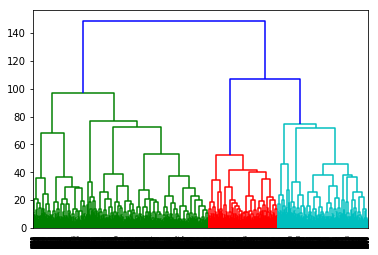

In [12]:
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(scaled_df, method='ward'))

In [13]:
# select 3 clusters
hc = AgglomerativeClustering(n_clusters=3, affinity = 'euclidean', linkage = 'ward')
clusters = hc.fit_predict(scaled_df)

In [14]:
z = all_data[clusters == 0]
o = all_data[clusters == 1]
t = all_data[clusters == 2]

## Analysis of Clusters

We overall come up with 3 separate user groups that we can roughly characterize as follows:

### CLUSTER ONE:
* Largest Cluster
* Primarily low-income students (least likely to purchase subscription)
* Recently picked up Duolingo, and do not frequently use it (low activity)
* Disproportionately from (relatively) english-speaking countries (Germany, US, Great Britain)
* Generally younger, with least amount of income

### CLUSTER TWO:
* Long time users — this is by far the biggest distinction of this cluster
* Most likely to have a subscription! (by 16%)
* Very dedicated users - longer streaks, utilizing more outside resources, earning more crowns
* Middle-aged with disposable income (most likely to be employed full time)
* Disproportionately from countries where English is relatively uncommon: Russia, Japan, Taiwan

### CLUSTER THREE:
* Casual users (more active than student, less active than the dedicated users)
* From an even mix of countries 
* Least likely to have taken the placement test
* Largest proportion of under 18 years


In [15]:
variables = ["longest_streak", "n_days_on_platform", "other_resources", "highest_crown_count"]
for v in variables:
    frame = pd.DataFrame()
    for i, c in enumerate([z, o, t], start=1):
        frame["Cluster %s" % i] = c[v].describe().values
    frame.index = c[v].describe().keys()
    frame.index.name = v
    display(frame)

,Cluster 1,Cluster 2,Cluster 3
longest_streak,,,
count,2874.000000,1478.000000,1136.000000
mean,32.120390,260.426928,71.045775
std,68.594056,306.820118,127.543927
min,0.000000,0.000000,0.000000
25%,2.000000,40.000000,4.000000
50%,8.000000,127.000000,16.000000
75%,30.000000,379.750000,70.000000
max,1211.000000,1820.000000,877.000000


,Cluster 1,Cluster 2,Cluster 3
n_days_on_platform,,,
count,2874.000000,1478.000000,1136.000000
mean,305.418232,631.405277,1411.136444
std,353.605199,497.037544,452.115567
min,2.000000,3.000000,20.000000
25%,43.000000,230.250000,1124.000000
50%,163.000000,513.500000,1445.500000
75%,467.750000,906.000000,1760.250000
max,2137.000000,2389.000000,2402.000000


,Cluster 1,Cluster 2,Cluster 3
other_resources,,,
count,2874.000000,1478.000000,1136.000000
mean,1.192067,1.610284,1.588908
std,1.111591,1.375264,1.407037
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000
max,8.000000,8.000000,9.000000


,Cluster 1,Cluster 2,Cluster 3
highest_crown_count,,,
count,2874.000000,1478.000000,1136.000000
mean,58.321851,189.512855,122.332746
std,58.684486,107.413044,89.176300
min,0.000000,0.000000,0.000000
25%,15.000000,118.000000,53.000000
50%,41.000000,175.000000,107.000000
75%,84.000000,244.000000,175.250000
max,607.000000,617.000000,490.000000


In [16]:
variables = ["age", "annual_income", "purchased_subscription", "student", "country", "took_placement_test", "employment_status"]
from collections import Counter

for v in variables: # v = "purchased_subscription"
    frame = dict()
    for i, c in enumerate([z, o, t], start=1):
        counted = Counter(c[v].values)
        frame["Cluster %s" % i] = [v / len(c) for k, v in sorted(counted.items())]
    data = pd.DataFrame(frame).transpose()
    data.index.name = v
    data.columns = sorted(counted.keys())
    display(data.transpose())


age,Cluster 1,Cluster 2,Cluster 3
18-34,0.348295,0.154263,0.375000
35 - 54,0.319763,0.402571,0.342430
55 - 74,0.216771,0.408660,0.235915
75 or older,0.018441,0.029770,0.029049
No Response,0.002088,0.000677,0.000880
Under 18,0.094642,0.004060,0.016725


annual_income,Cluster 1,Cluster 2,Cluster 3
"$0 - $10,000",0.389701,0.179296,0.271127
"$11,000 - $25,000",0.183020,0.165765,0.158451
"$151,000 or more",0.037230,0.089310,0.061620
"$26,000 - $75,000",0.201113,0.308525,0.294014
"$76,000 - $150,000",0.069241,0.146820,0.123239
No Response,0.119694,0.110284,0.091549


purchased_subscription,Cluster 1,Cluster 2,Cluster 3
False,0.784273,0.437754,0.654049
True,0.215727,0.562246,0.345951


student,Cluster 1,Cluster 2,Cluster 3
Full-time student,0.193111,0.013532,0.095070
No Response,0.052540,0.066982,0.040493
Not currently a student,0.679193,0.904601,0.779049
Part-time student,0.075157,0.014885,0.085387


country,Cluster 1,Cluster 2,Cluster 3
BR,0.082116,0.033829,0.043134
CO,0.048713,0.034506,0.065141
DE,0.112387,0.075778,0.089789
FR,0.149965,0.236806,0.127641
GB,0.144746,0.062923,0.057218
JP,0.115170,0.177267,0.194542
MX,0.130480,0.183356,0.147887
RU,0.085595,0.142760,0.146127
TW,0.042797,0.026387,0.061620
US,0.088031,0.026387,0.066901


took_placement_test,Cluster 1,Cluster 2,Cluster 3
False,0.614823,0.433018,0.609155
True,0.385177,0.566982,0.390845


employment_status,Cluster 1,Cluster 2,Cluster 3
Employed full-time,0.450939,0.540595,0.578345
Employed part-time,0.165971,0.114344,0.124120
No Response,0.029923,0.005413,0.007923
Retired,0.140919,0.259134,0.171655
Unemployed,0.212248,0.080514,0.117958
